In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [34]:
train = pd.read_csv("data/sign_mnist_train.csv")
test = pd.read_csv("data/sign_mnist_test.csv")
print(train.shape, test.shape)
train.head()

(27455, 785) (7172, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
labels = {0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 6: "G", 7: "H", 
          8: "I", 9: "J", 10: "K", 11: "L", 12: "M", 13: "N", 14: "O", 
          15: "P", 16: "Q", 17: "R", 18: "S", 19: "T", 20: "U", 21: "V", 
          22: "W", 23: "X", 24: "Y", 25: "Z"}

In [81]:
def display_n_images(data, n, height, width, random_state=None):

    sample = data.sample(n, random_state=random_state)
    cols = 5
    rows = int(n / 5 + 0.5)

    fig, axs = plt.subplots(rows, cols)
    i = 0
    for index, row in sample.iterrows():
        irow = i // cols
        icol = i % cols

        axs[irow, icol].imshow(row.values[1:].reshape(height, width))
        i += 1
        axs[irow, icol].set_title(labels[row.iloc[0]])
    
    plt.tight_layout()
    plt.show()

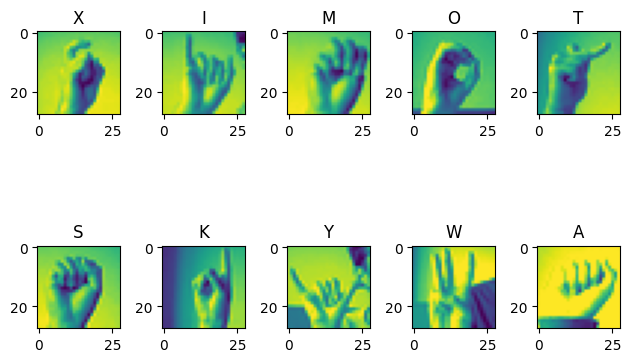

In [82]:
display_n_images(train, 10, 28, 28, random_state=40)

In [35]:
X_train = train.drop(columns=["label"])
y_train = train["label"]

X_test = test.drop(columns=["label"])
y_test = test["label"]

In [ ]:
# We can see some letters are slightly underrepresented. For instance, R has 1294 instances while E has 957.
train.label.replace(labels).value_counts()

label
R    1294
Q    1279
L    1241
W    1225
F    1204
S    1199
O    1196
D    1196
T    1186
X    1164
I    1162
U    1161
N    1151
C    1144
A    1126
Y    1118
K    1114
G    1090
P    1088
V    1082
M    1055
H    1013
B    1010
E     957
Name: count, dtype: int64

In [36]:
## Aplicar estandarización para mejorar el desempeño del algoritmo de PCA

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

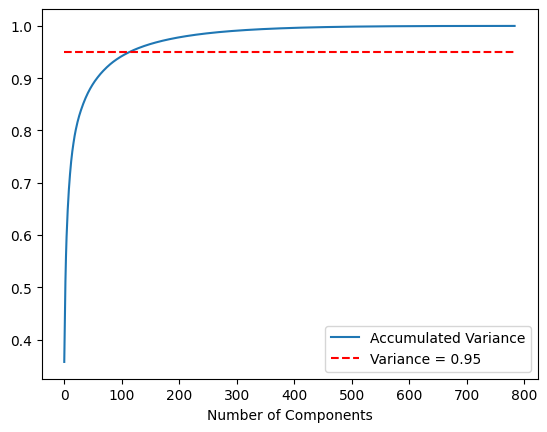

In [58]:
pca = PCA()
pca.fit(X_train_scaled)

plt.figure()
plt.plot(pca.explained_variance_ratio_.cumsum(), label="Accumulated Variance")
plt.hlines(0.95, xmin=0, xmax=X_train.shape[1], color="red", linestyles="dashed", label="Variance = 0.95")
plt.xlabel("Number of Components")
plt.legend()
plt.show()

In [ ]:
# Al preservar una varianza del 95% se reduce la dimensionalidad de 784 a 115
pca95 = PCA(0.95)
X_train_pca = pca95.fit_transform(X_train_scaled, y_train)
X_train_pca.shape

(27455, 115)

In [ ]:
# Volvemos al espacio original para ver cómo se afectaron los datos luego de la conversión

X_train_reduced = pca95.inverse_transform(X_train_pca)
X_train_reduced.shape

(27455, 784)

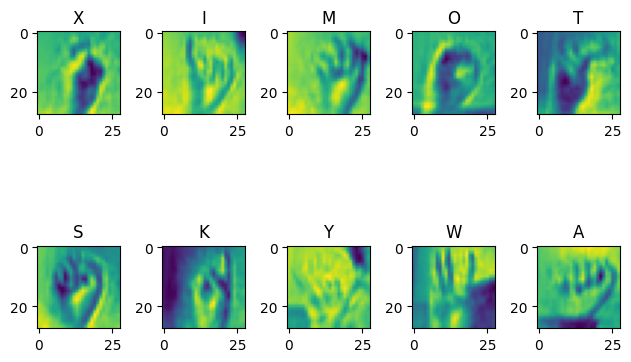

In [83]:
display_n_images(
    pd.concat(
        [y_train, pd.DataFrame(X_train_reduced)],
         axis=1
    ),
    10, 
    28, 
    28,
    random_state=40
)

A pesar de utilizar el 95% de la varianza, se observa una pérdida de precisión significativa con respecto a las imágenes originales.

## Selección del mejor modelo

In [88]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)


In [84]:
kfold = KFold(n_splits=10, shuffle=True, random_state=40)

knn_grid = {
    "model__n_neighbors": [3, 5, 10, 15],
    "model__weights": ['uniform', 'distance'],
}

knn_pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("dim_reduction", PCA(0.95)),
        ("model", KNeighborsClassifier())
    ]
)

knn_grid = GridSearchCV(
    knn_pipe,
    knn_grid,
    scoring="accuracy",
    cv=kfold,
    n_jobs=-1,
)

knn_grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=40, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('dim_reduction',
                                        PCA(n_components=0.95)),
                                       ('model', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'model__n_neighbors': [3, 5, 10, 15],
                         'model__weights': ['uniform', 'distance']},
             scoring='accuracy')

In [86]:
knn_grid.best_params_

{'model__n_neighbors': 3, 'model__weights': 'distance'}

In [87]:
knn_grid.best_score_

np.float64(0.9983973376741396)

In [90]:
y_test_pred = knn_grid.predict(X_test)

print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       0.91      1.00      0.95       331
           1       0.95      0.91      0.93       432
           2       0.98      1.00      0.99       310
           3       0.80      0.94      0.86       245
           4       0.77      0.98      0.86       498
           5       0.98      0.98      0.98       247
           6       0.95      0.93      0.94       348
           7       0.97      0.97      0.97       436
           8       0.94      0.70      0.81       288
          10       0.81      0.66      0.73       331
          11       0.97      0.93      0.95       209
          12       0.80      0.57      0.67       394
          13       0.82      0.67      0.74       291
          14       1.00      0.94      0.97       246
          15       0.99      0.99      0.99       347
          16       0.91      1.00      0.95       164
          17       0.40      0.60      0.48       144
          18       0.65    

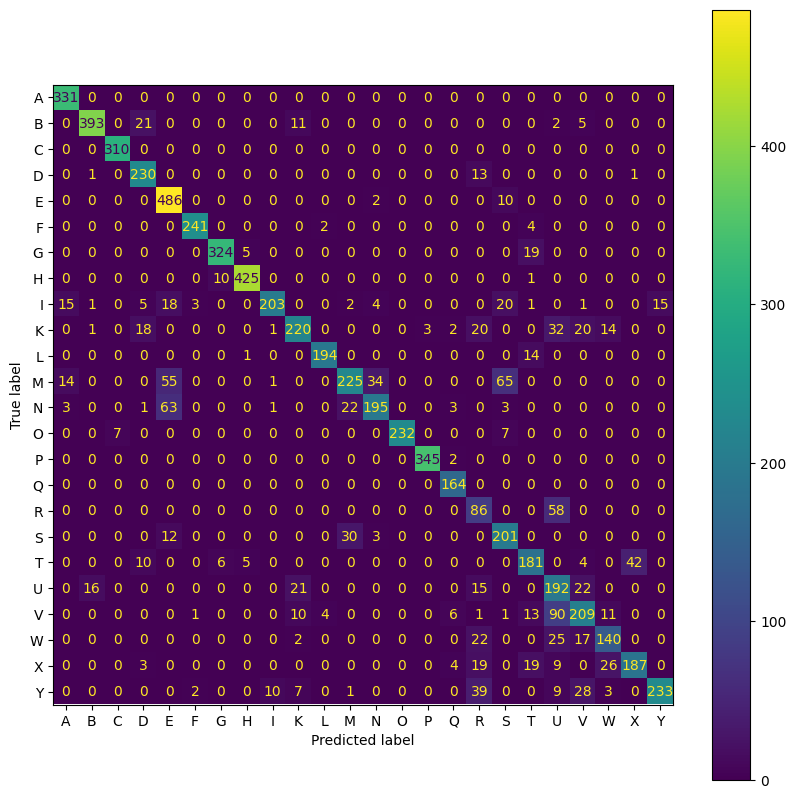

In [ ]:
knn_cm = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots(1,1, figsize=(10, 10))

disp = ConfusionMatrixDisplay(
    knn_cm,
    display_labels=[letter for letter in labels.values() if letter not in ("J", "Z")],
)
disp.plot(ax=ax)

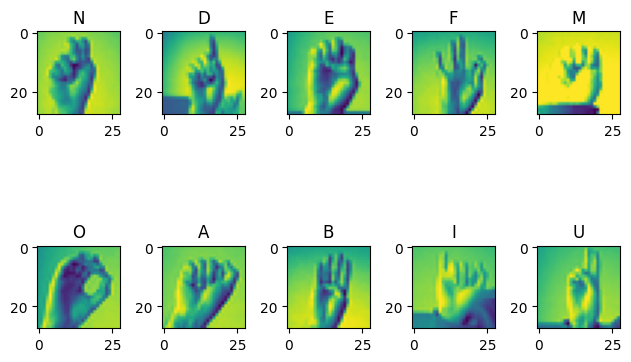

In [111]:
display_n_images(
    pd.concat(
        [y_test, X_test],
        axis=1
    ),
    10,
    28,
    28,
    random_state=40
)

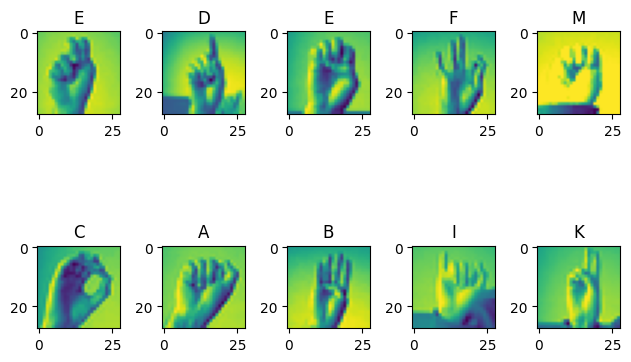

In [108]:
display_n_images(
    pd.concat(
        [pd.Series(y_test_pred), X_test],
        axis=1
    ),
    10,
    28,
    28,
    random_state=40
)

La primera, sexta y décima imagen representaban "N", "O" y "U", pero fueron clasificadas erróneamente como "E", "C", y "K". Las demás letras se clasificaron correctamente.

In [104]:
best_knn = knn_grid.best_estimator_

In [106]:
# Save the model and use it somewhere else for prediction

import joblib

joblib.dump(best_knn, "./best_knn.joblib")

['./best_knn.joblib']